The length of smiles character is 56
Initial input shape: torch.Size([1, 350, 56])
Input shape after permute for conv layers: torch.Size([1, 56, 350])
Shape after conv layer 0: torch.Size([1, 64, 175])
Shape after conv layer 1: torch.Size([1, 64, 87])
Shape after conv layer 2: torch.Size([1, 64, 43])
Shape after conv layer 3: torch.Size([1, 64, 21])
Shape after conv layer 4: torch.Size([1, 64, 10])
Feature maps shape (last conv layer output): torch.Size([1, 64, 10])
Shape before LSTM: torch.Size([1, 10, 64])
Shape after LSTM: torch.Size([1, 10, 64])
Attention output shape: torch.Size([1, 10, 64])
Logits: tensor([[ 2.7742,  0.1190, -2.4334]])
Output shape after FC layer: torch.Size([1, 3])
Probabilities: tensor([[0.9296, 0.0653, 0.0051]])
O=S(=O)(NCCCCCn1c(C2CCNCC2)nc2cc(Cl)c(Cl)cc21)c1ccccc1 probabilities: [0.929577   0.06533381 0.00508917] -> Predicted to be Inactive with a probability of 0.930 or 93.0%
Initial input shape: torch.Size([1, 350, 56])
Input shape after permute for conv l

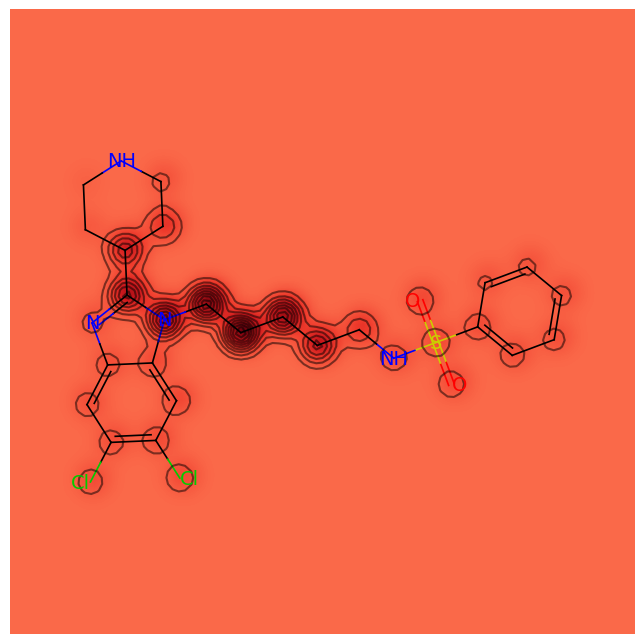

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Function
import torch.nn.functional as F
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from scipy.interpolate import interp1d
from model import ConvLSTMCAMbiotic  
from data_preprocessing2 import smiles_chars
from PIL import Image
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from rdkit.Chem import Descriptors
from scipy.interpolate import CubicSpline
from rdkit.Chem import AllChem
import warnings
warnings.filterwarnings("ignore")



def smiles_to_tensor(smile, char_to_index, maxlen=350):
    """
    Convert a single SMILES string to a PyTorch tensor.
    
    Args:
    - smile (str): The SMILES string to be converted.
    - char_to_index (dict): A dictionary mapping characters to indices.
    - maxlen (int): Maximum length of the sequence to be padded to.
    
    Returns:
    - torch.Tensor: A PyTorch tensor representing the one-hot encoded SMILES.
    """
    # Convert the SMILES string to a one-hot encoded sequence
    encoded = np.zeros((maxlen, len(char_to_index)), dtype=np.int8)
    for i, char in enumerate(smile):
        if i < maxlen:  # Ensure index doesn't exceed maxlen - 1
            if char in char_to_index:
                encoded[i, char_to_index[char]] = 1
        else:
            break  # Break the loop if index equals or exceeds maxlen
    
    # Convert the numpy array to a PyTorch tensor
    encoded_tensor = torch.from_numpy(encoded).unsqueeze(0)  # Add batch dimension
    encoded_tensor = encoded_tensor.to(dtype=torch.float32)  # Model might expect float
    return encoded_tensor


def register_custom_colormap():
    # Custom diverging colormap: red (negative) to white (neutral) to blue (positive)
    cmap = LinearSegmentedColormap.from_list(
        "red_blue",
        ["red", "white", "blue"],
        N=256
    )
    try:
        plt.register_cmap(name="red_blue", cmap=cmap)
    except ValueError:
        pass  # The colormap is already registered

# Register the colormap at the start of your script.
register_custom_colormap()



# Calculate molecular weight using RDKit
def calculate_molecular_weight(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Descriptors.ExactMolWt(mol) if mol else None

# Filter single SMILES string based on specified criteria
def filter_single_smile(smile, maxlen=350, max_mol_wt=650):
    reasons = []
    mol_wt = calculate_molecular_weight(smile)
    
    if len(smile) > maxlen:
        reasons.append('maxlen exceeded')
    if not all(char in smiles_chars for char in smile):
        reasons.append('invalid character')
    if mol_wt is None or mol_wt > max_mol_wt:
        reasons.append('mol wt exceeded')
    
    return ', '.join(reasons) if reasons else 'valid'



# Main prediction function that incorporates SMILES filtering

def predict_smiles(model, smile, maxlen=350, max_mol_wt=650):
    filter_result = filter_single_smile(smile, maxlen, max_mol_wt)
    
    if filter_result != 'valid':
        print(f"This SMILES cannot be predicted because: {filter_result}.")
        return None, None

    char_to_index = {char: idx for idx, char in enumerate(smiles_chars)}
    input_tensor = smiles_to_tensor(smile, char_to_index, maxlen).to(model.device)

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Get the model's output directly from the forward method
        output = model(input_tensor)
        # The model's forward method returns a tuple, unpack to get probabilities
        probabilities, _, _ = output
        # Move probabilities to CPU and convert to numpy array
        probabilities = probabilities.cpu().numpy()[0]
        predicted_class_index = np.argmax(probabilities)
        predicted_probability = probabilities[predicted_class_index]
    
    # Define class labels in the order they are output by the model
    classes = ["Inactive", "Slightly Active", "Active"]
    prediction_message = f"{smile} probabilities: {probabilities} -> Predicted to be {classes[predicted_class_index]} with a probability of {predicted_probability:.3f} or {predicted_probability*100:.1f}%"
    print(prediction_message)
    return predicted_class_index, probabilities

class SimplifiedAttentionVisualizer:
    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device
        self.model.eval()

    def prepare_input(self, smiles):
        char_to_index = {char: idx for idx, char in enumerate(smiles_chars)}
        input_tensor = smiles_to_tensor(smiles, char_to_index).to(self.device)
        return input_tensor
    
    def visualize_attention_for_smiles(self, smiles, output_image_path, prediction_class, attention_heads='average'):

        input_tensor = self.prepare_input(smiles)
        with torch.no_grad():
            _, attention_weights, _ = self.model(input_tensor)
            
            if attention_heads == 'average':
                # Average across heads (dim=1 for [batch_size, num_heads, seq_len, seq_len])
                avg_attention = attention_weights.mean(dim=1).squeeze(0)
            else:
                # Or select a specific head
                avg_attention = attention_weights[0, attention_heads, :, :]

            # Process attention weights for visualization
            attention_weights_processed = avg_attention.cpu().detach().numpy()
        
        # Interpolate and overlay attention weights
        atom_attention_weights = self.interpolate_attention_to_atoms(smiles, attention_weights_processed)
        
        # Choose colormap based on prediction class
        if prediction_class == 'Inactive':
            cmap = 'Reds'
        elif prediction_class == 'Slightly Active':
            cmap = 'YlOrRd_r'  
        else:
            cmap = 'Greens'

            
        self.overlay_attention_on_molecule(smiles, atom_attention_weights, output_image_path, cmap=cmap)

    def interpolate_attention_to_atoms(self, smiles, attention_weights, method='linear'):
        mol = Chem.MolFromSmiles(smiles)
        num_atoms = mol.GetNumAtoms()
        
        # Attention weights shape: [seq_len, seq_len]
        seq_len = attention_weights.shape[0]

        # Interpolate attention weights to match the number of atoms
        interpolate = interp1d(np.arange(seq_len), attention_weights, kind=method, fill_value="extrapolate")
        new_attention_weights = interpolate(np.linspace(0, seq_len - 1, num_atoms))

        return new_attention_weights



    def overlay_attention_on_molecule(self, smiles, attention_weights, output_image_path, cmap='viridis'):
        mol = Chem.MolFromSmiles(smiles)
        
        # Compute the 2D coordinates for consistent positioning
        AllChem.Compute2DCoords(mol)
        
        # Normalize attention weights across the full range for visualization
        norm = Normalize(vmin=np.min(attention_weights), vmax=np.max(attention_weights))
        normalized_weights = [norm(weight) for weight in attention_weights]
        
        fig, ax = plt.subplots()
        fig.patch.set_facecolor('white')
        
        # Use the specified colormap for visualization
        SimilarityMaps.GetSimilarityMapFromWeights(
            mol, normalized_weights, colorMap=plt.get_cmap(cmap), contourLines=10
        )
        
        plt.axis('off')
        plt.savefig(output_image_path, bbox_inches='tight')
        plt.close(fig)



if __name__ == "__main__":

    model_checkpoint_path = 'Seed Randomization_SA/models500/checkpoint-epoch=198-val_loss=0.67.ckpt' # replace with model checkpoint path
    #model_checkpoint_path = 'Seed Randomization_SA/models50/checkpoint-epoch=197-val_loss=0.67.ckpt'
    #model_checkpoint_path = 'Seed Randomization_SA/models5/checkpoint-epoch=196-val_loss=0.67.ckpt'
    trained_model = ConvLSTMCAMbiotic.load_from_checkpoint(model_checkpoint_path)
    visualizer = SimplifiedAttentionVisualizer(trained_model, device='cuda' if torch.cuda.is_available() else 'cpu')




    smiles ='O=S(=O)(NCCCCCn1c(C2CCNCC2)nc2cc(Cl)c(Cl)cc21)c1ccccc1' #inactive example

    # Make prediction to determine the class index and probabilities
    predicted_class_index, _ = predict_smiles(trained_model, smiles)
    classes = ["Inactive", "Slightly Active", "Active"]
    prediction_class = classes[predicted_class_index]  # use 'prediction_class' instead of 'predicted_class'
    
    visualizer.visualize_attention_for_smiles(smiles, 'final_class_attention_overlay.png', prediction_class=prediction_class, attention_heads='average')
    #predicted_class_index, probabilities = predict_smiles(trained_model, smiles)
    prediction, probabilities = predict_smiles(trained_model, smiles)
